<a href="https://colab.research.google.com/github/junyeog/deep-learning-project/blob/main/Gender_classification_v7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [9]:
df=pd.read_csv("/content/drive/MyDrive/project/gender_classification_v7.csv")


--- 데이터 기본 정보 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   long_hair                  5001 non-null   int64  
 1   forehead_width_cm          5001 non-null   float64
 2   forehead_height_cm         5001 non-null   float64
 3   nose_wide                  5001 non-null   int64  
 4   nose_long                  5001 non-null   int64  
 5   lips_thin                  5001 non-null   int64  
 6   distance_nose_to_lip_long  5001 non-null   int64  
 7   gender                     5001 non-null   object 
dtypes: float64(2), int64(5), object(1)
memory usage: 312.7+ KB
None

--- 데이터 상위 5개 행 ---
   long_hair  forehead_width_cm  forehead_height_cm  nose_wide  nose_long  \
0          1               11.8                 6.1          1          0   
1          0               14.0                 5.4          0         

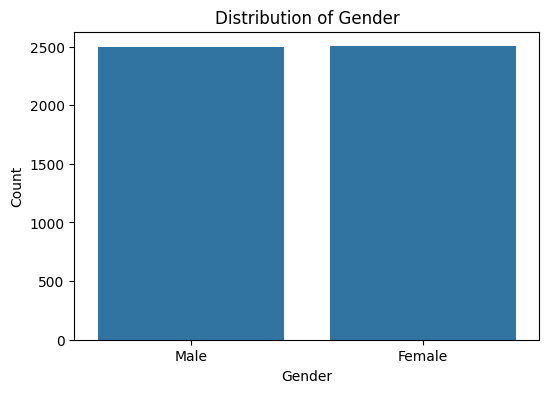

In [10]:
print("\n--- 데이터 기본 정보 ---")
print(df.info())

# 데이터 상위 5개 행 확인
print("\n--- 데이터 상위 5개 행 ---")
print(df.head())

# 기술 통계량 확인
print("\n--- 기술 통계량 ---")
print(df.describe())

# 결측치 확인
print("\n--- 결측치 확인 ---")
print(df.isnull().sum())

# 'gender' 컬럼의 유니크 값 및 분포 확인 (타겟 변수)
print("\n--- 'gender' 컬럼 유니크 값 ---")
print(df['gender'].unique())
print("\n--- 'gender' 컬럼 분포 ---")
print(df['gender'].value_counts())
print("\n--- 'gender' 컬럼 분포 (비율) ---")
print(df['gender'].value_counts(normalize=True))

# 성별 분포 시각화
plt.figure(figsize=(6, 4))
sns.countplot(x='gender', data=df)
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()


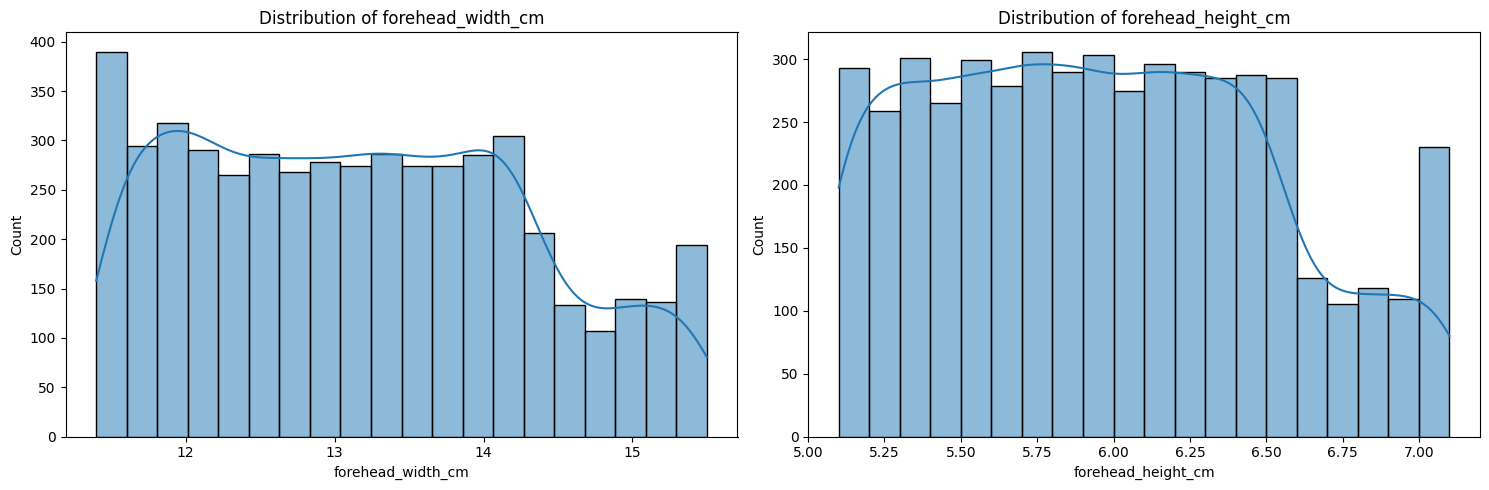

In [11]:
numeric_cols = ['forehead_width_cm', 'forehead_height_cm']
plt.figure(figsize=(15, 5))
for i, col in enumerate(numeric_cols):
    plt.subplot(1, len(numeric_cols), i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


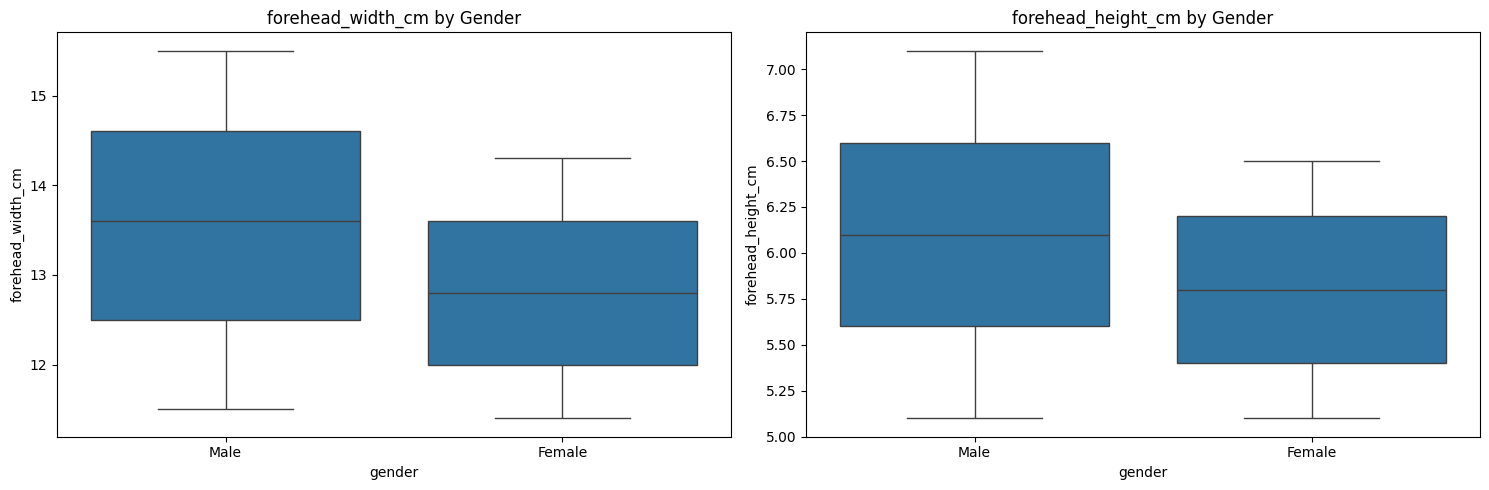

In [12]:
plt.figure(figsize=(15, 5))
for i, col in enumerate(numeric_cols):
    plt.subplot(1, len(numeric_cols), i + 1)
    sns.boxplot(x='gender', y=col, data=df)
    plt.title(f'{col} by Gender')
plt.tight_layout()
plt.show()

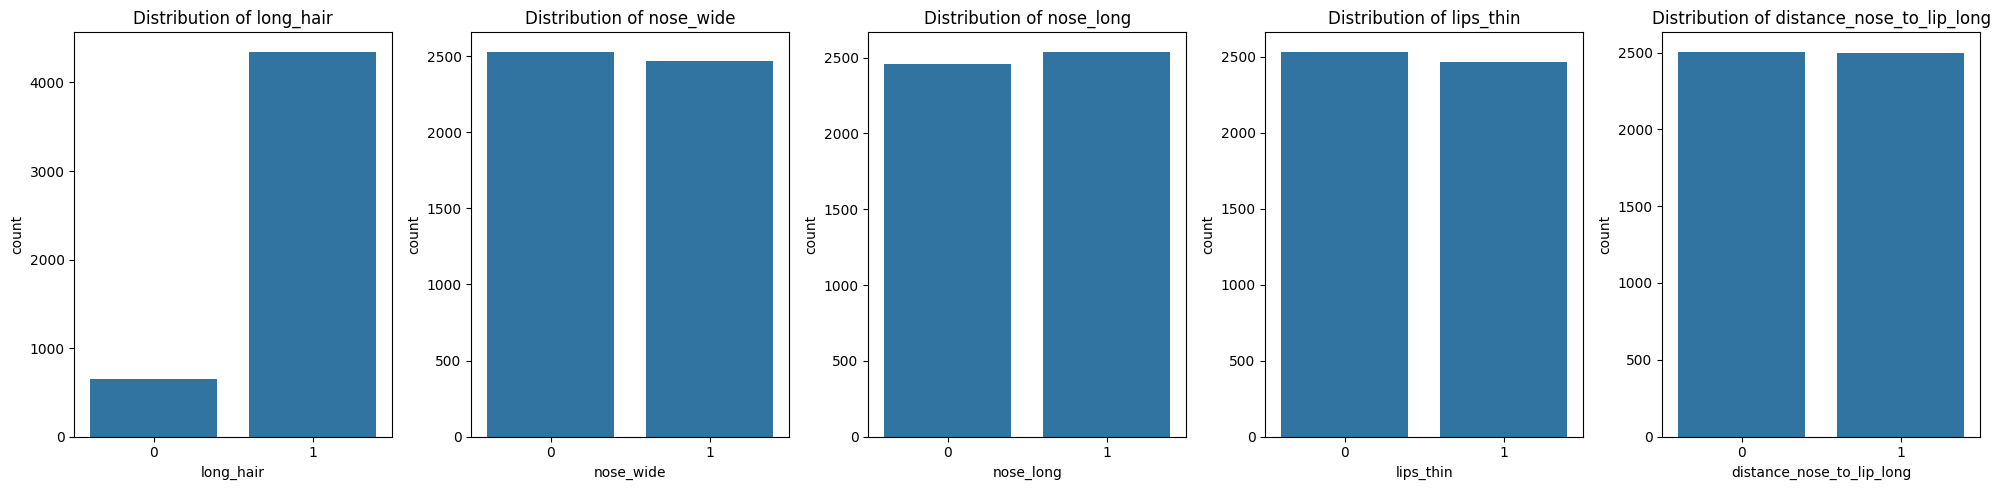

In [13]:
binary_cols = ['long_hair', 'nose_wide', 'nose_long', 'lips_thin', 'distance_nose_to_lip_long']
plt.figure(figsize=(20, 5))
for i, col in enumerate(binary_cols):
    plt.subplot(1, len(binary_cols), i + 1)
    sns.countplot(x=col, data=df)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

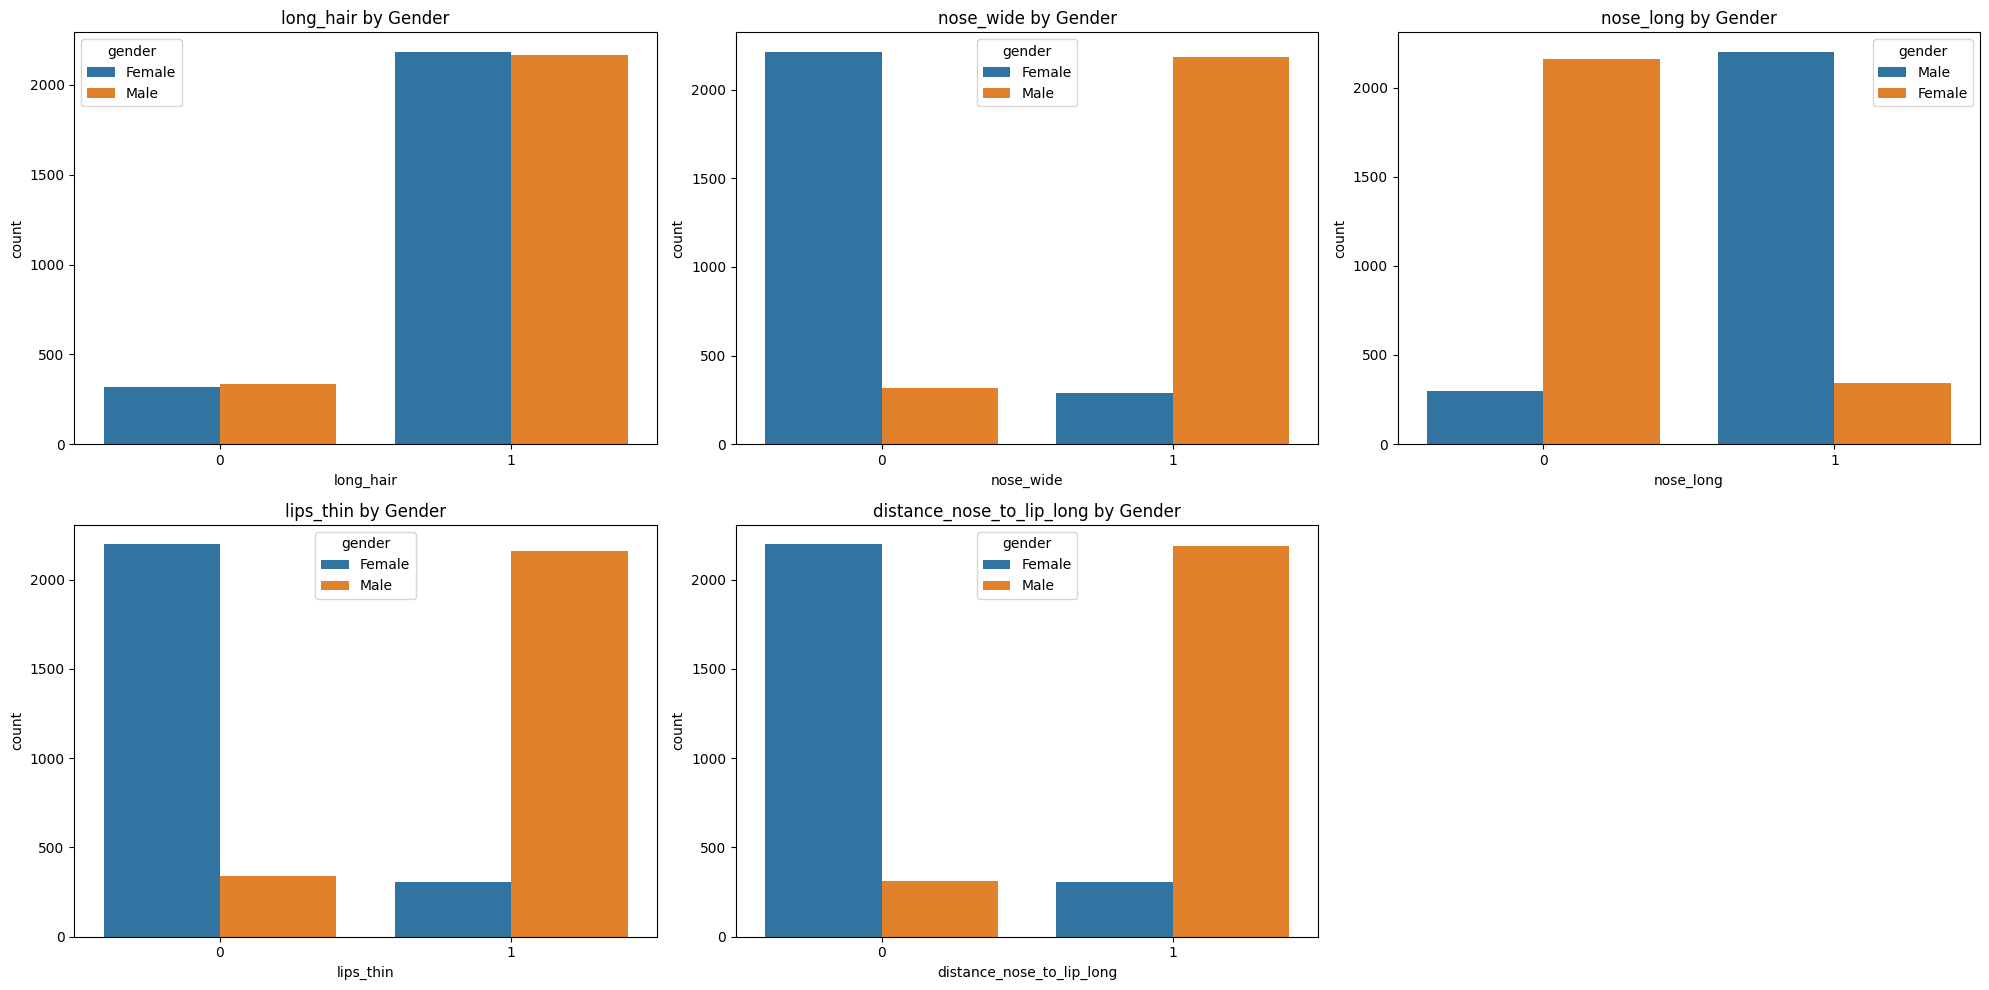

In [14]:
plt.figure(figsize=(20, 10))
for i, col in enumerate(binary_cols):
    plt.subplot(2, 3, i + 1) # 2행 3열로 배치
    sns.countplot(x=col, hue='gender', data=df)
    plt.title(f'{col} by Gender')
plt.tight_layout()
plt.show()

In [15]:
# 'gender' 컬럼을 숫자로 인코딩 (LabelEncoder 사용)
le = LabelEncoder()
df['gender_encoded'] = le.fit_transform(df['gender'])

print("\n--- 인코딩된 'gender' 컬럼 유니크 값 ---")
print(df['gender_encoded'].unique())
print(f"인코딩된 성별 매핑: {list(le.classes_)} -> {le.transform(le.classes_)}")

# 특징(X)과 타겟(y) 분리
# 'gender' 원본 컬럼과 'gender_encoded'는 특징에서 제외합니다.
features = ['long_hair', 'forehead_width_cm', 'forehead_height_cm',
            'nose_wide', 'nose_long', 'lips_thin', 'distance_nose_to_lip_long']
X = df[features]
y = df['gender_encoded']

# 훈련 세트와 테스트 세트 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# 수치형 특징 스케일링
# 'forehead_width_cm', 'forehead_height_cm'만 스케일링합니다.
numeric_features = ['forehead_width_cm', 'forehead_height_cm']

scaler = StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

print("\n--- 수치형 특징 스케일링 완료 (X_train 상위 5개 행) ---")
print(X_train.head())


--- 인코딩된 'gender' 컬럼 유니크 값 ---
[1 0]
인코딩된 성별 매핑: ['Female', 'Male'] -> [0 1]

--- 수치형 특징 스케일링 완료 (X_train 상위 5개 행) ---
      long_hair  forehead_width_cm  forehead_height_cm  nose_wide  nose_long  \
2771          1          -0.436837           -0.279593          1          1   
627           1           2.000566            1.744775          1          1   
1102          1           2.000566            1.744775          1          1   
1261          1           0.285357            0.640574          1          0   
1618          1          -1.339578           -1.567827          0          0   

      lips_thin  distance_nose_to_lip_long  
2771          1                          1  
627           1                          1  
1102          0                          1  
1261          1                          0  
1618          0                          1  


In [16]:
# 모델 초기화
model = LogisticRegression(random_state=42)

# 모델 훈련
print("\n--- 모델 훈련 시작 ---")
model.fit(X_train, y_train)
print("모델 훈련 완료!")


--- 모델 훈련 시작 ---
모델 훈련 완료!



--- 모델 평가 결과 (Logistic Regression) ---
정확도 (Accuracy): 0.9640
정밀도 (Precision): 0.9640
재현율 (Recall): 0.9640
F1-Score: 0.9640
ROC-AUC Score: 0.9964


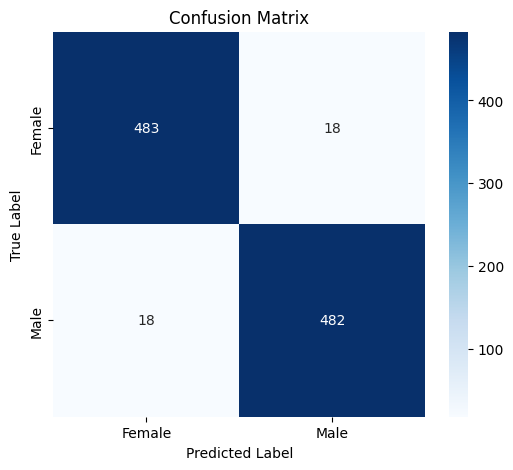

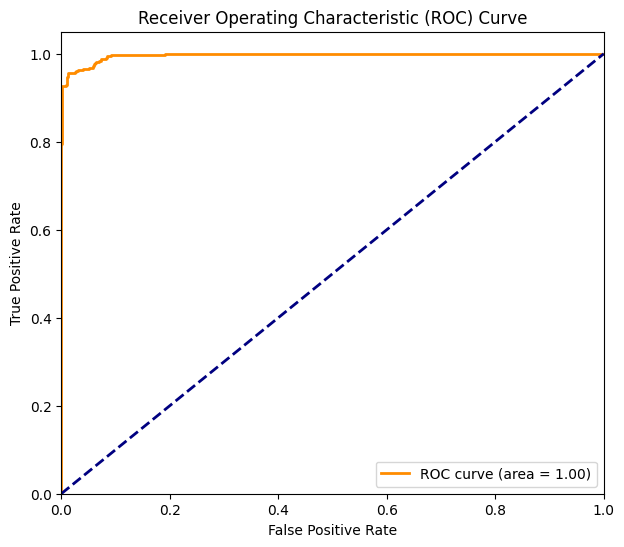

In [17]:
# 테스트 세트에 대한 예측
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1] # ROC-AUC를 위한 예측 확률

# 평가 지표 계산
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"\n--- 모델 평가 결과 (Logistic Regression) ---")
print(f"정확도 (Accuracy): {accuracy:.4f}")
print(f"정밀도 (Precision): {precision:.4f}")
print(f"재현율 (Recall): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

# 오차 행렬 시각화
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC 곡선 시각화
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [18]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM (RBF Kernel)': SVC(probability=True, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
}


--- 여러 모델 훈련 및 평가 시작 ---

모델: Logistic Regression 훈련 중...
  정확도 (Accuracy): 0.9640
  정밀도 (Precision): 0.9640
  재현율 (Recall): 0.9640
  F1-Score: 0.9640
  ROC-AUC Score: 0.9964

모델: Decision Tree 훈련 중...
  정확도 (Accuracy): 0.9660
  정밀도 (Precision): 0.9736
  재현율 (Recall): 0.9580
  F1-Score: 0.9657
  ROC-AUC Score: 0.9660

모델: Random Forest 훈련 중...
  정확도 (Accuracy): 0.9690
  정밀도 (Precision): 0.9796
  재현율 (Recall): 0.9580
  F1-Score: 0.9687
  ROC-AUC Score: 0.9942

모델: SVM (RBF Kernel) 훈련 중...
  정확도 (Accuracy): 0.9760
  정밀도 (Precision): 0.9917
  재현율 (Recall): 0.9600
  F1-Score: 0.9756
  ROC-AUC Score: 0.9966

모델: K-Nearest Neighbors 훈련 중...
  정확도 (Accuracy): 0.9670
  정밀도 (Precision): 0.9834
  재현율 (Recall): 0.9500
  F1-Score: 0.9664
  ROC-AUC Score: 0.9896

--- 모든 모델 평가 완료 ---

--- 모델별 성능 요약 ---
                     Accuracy  Precision  Recall  F1-Score  ROC-AUC
Model                                                              
SVM (RBF Kernel)        0.976     0.9917   0.960    0.9756   0.

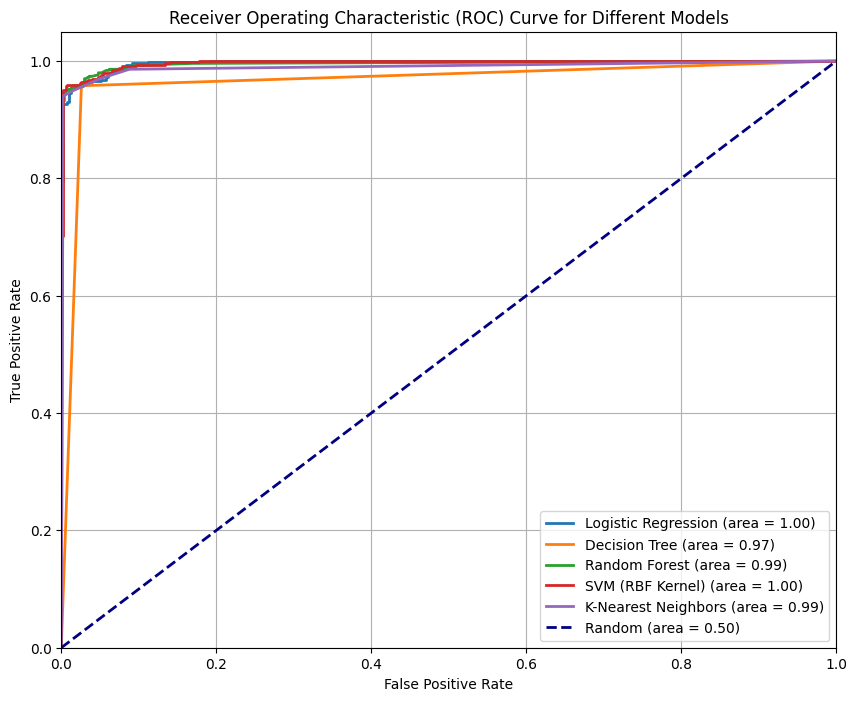

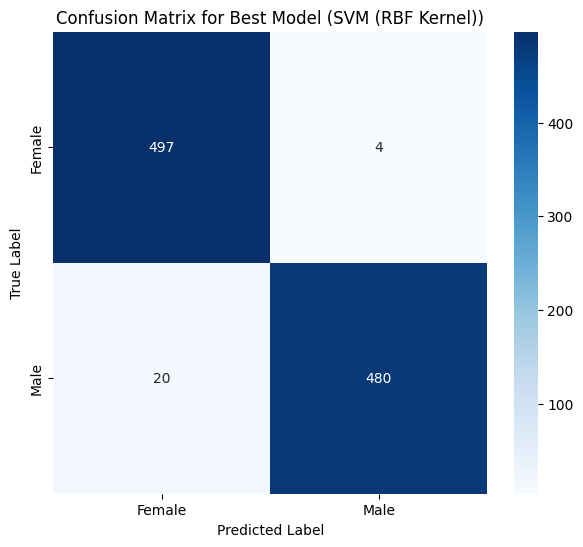

In [ ]:
results = []
roc_curves = {}

print("\n--- 여러 모델 훈련 및 평가 시작 ---")

for name, model in models.items():
    print(f"\n모델: {name} 훈련 중...")
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    try:
        y_prob = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_curves[name] = (fpr, tpr)
    except AttributeError:
        y_prob = None
        roc_auc = np.nan
        print(f"경고: {name}은 predict_proba를 지원하지 않아 ROC-AUC를 계산할 수 없습니다.")


    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    })

    print(f"  정확도 (Accuracy): {accuracy:.4f}")
    print(f"  정밀도 (Precision): {precision:.4f}")
    print(f"  재현율 (Recall): {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    if not np.isnan(roc_auc):
        print(f"  ROC-AUC Score: {roc_auc:.4f}")
    else:
        print(f"  ROC-AUC Score: N/A")

print("\n--- 모든 모델 평가 완료 ---")

# 결과 요약 테이블 출력
results_df = pd.DataFrame(results).set_index('Model').sort_values(by='F1-Score', ascending=False)
print("\n--- 모델별 성능 요약 ---")
print(results_df.round(4))

# 모든 모델의 ROC 곡선 시각화
plt.figure(figsize=(10, 8))
for name, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, lw=2, label=f'{name} (area = {results_df.loc[name, "ROC-AUC"]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random (area = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Different Models')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

best_model_name = results_df.index[0]
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test)
cm_best = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(7, 6))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Confusion Matrix for Best Model ({best_model_name})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


--- MLP 모델 요약 ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,625 (10.25 KB)

 Trainable params: 2,625 (10.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7513 - loss: 0.5314 - val_accuracy: 0.9638 - val_loss: 0.1737
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9456 - loss: 0.1726 - val_accuracy: 0.9700 - val_loss: 0.0919
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9519 - loss: 0.1292 - val_accuracy: 0.9750 - val_loss: 0.0836
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9591 - loss: 0.1070 - val_accuracy: 0.9750 - val_loss: 0.0805
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9660 - loss: 0.0938 - val_accuracy: 0.9700 - val_loss: 0.0818
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9715 - loss: 0.0770 - val_accuracy: 0.9750 - val_loss: 0.0773
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9683 - loss: 0.0954 - val_accuracy: 0.9750 - val_loss: 0.0754
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9593 - loss: 0.0922 - val_accuracy: 0

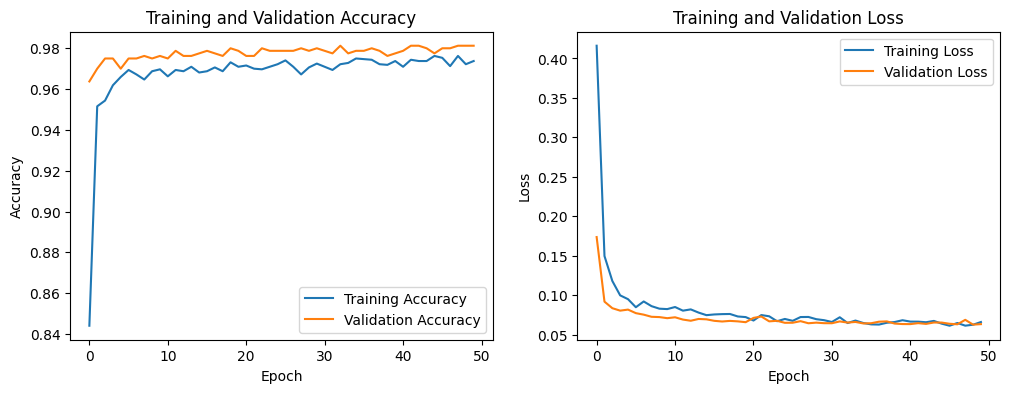

In [20]:

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)), # 입력 특성의 개수에 맞게 input_shape 설정
    Dropout(0.3), # 과적합 방지
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid') # 이진 분류를 위한 시그모이드 활성화 함수
])

# 모델 요약 출력
print("\n--- MLP 모델 요약 ---")
model.summary()

# 6. 모델 컴파일
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 7. 모델 학습
# validation_split을 사용하여 훈련 데이터 중 일부를 검증용으로 사용
history = model.fit(X_train, y_train,
                    epochs=50, # 에포크 수를 늘려서 더 학습
                    batch_size=32,
                    validation_split=0.2, # 훈련 데이터의 20%를 검증 데이터로 사용
                    verbose=1) # 학습 과정 출력

# 8. 모델 평가
print("\n--- 테스트 세트에서 모델 평가 ---")
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"테스트 정확도: {accuracy:.4f}")
print(f"테스트 손실: {loss:.4f}")

# 9. 학습 결과 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()